# Expressions

ironArray has a strong support for expression evaluation.  Things like sums, products, divisions or a pretty complete range of transcendental functions (e.g. `exp`, `sin`, `asin`, `tanh`...).  Fast evaluation of (large) arrays is one of the features that received more love during the development.  Performance comes from a balance between:

1. Use of [Intel MKL](https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html) for accelerating transcendental functions.

2. Use of [Intel SVML](https://software.intel.com/content/www/us/en/develop/documentation/cpp-compiler-developer-guide-and-reference/top/compiler-reference/intrinsics/intrinsics-for-short-vector-math-library-operations/overview-intrinsics-for-short-vector-math-library-svml-functions.html) for computing vector math functions.

3. Use of multi-threading capabilities.

4. Leveraging the 2-level partitioning in ironArray arrays so that most of the computation intensive happens inside private caches (L1, L2), which benefits multi-threading performance.

You can access to the powerful evaluation capabilities in ironArray in different ways, which we are going to succinctly expose in this tutorial.  In order to do that, we are going to make use of the dataset that we created in our reductions tutorial.  Let's go:


In [1]:
import numpy as np
import iarray as ia
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 98.812 MiB


In [2]:
ia_precip = ia.load("precip-3m.iarr")

In [2] used 4.141 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 102.953 MiB


Now, in order to evaluate some expressions on this, let's put the data for each month on a different array:

In [3]:
precip1 = ia_precip[0].copy()
precip2 = ia_precip[1].copy()
precip3 = ia_precip[2].copy()

In [3] used 1586.758 MiB RAM in 20.413s, peaked 0.004 MiB above current, total RAM usage 1689.711 MiB


Note how, even if the data for all the three months takes almost 9 GB uncompressed, ironArray has used just a bit more than 1.7 GB for holding them in RAM.  This is compression at work.

With that, let's compute something easy, like a new array with the mean of these.  For that, we are going to use the internal evaluation engine:

In [4]:
precip_expr = ia.expr_from_string("(p1 + p2 + p3) / 3", {'p1': precip1, 'p2': precip2, 'p3': precip3})

In [4] used 11.711 MiB RAM in 0.021s, peaked 0.000 MiB above current, total RAM usage 1701.422 MiB


Ok, that was fast, but we did not quite evaluate anything yet.  In order to do the actual evaluation, we have to call `.eval()` on the expression:

In [5]:
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

In [5] used 1249.672 MiB RAM in 1.588s, peaked 0.000 MiB above current, total RAM usage 2951.094 MiB


In [6]:
meas = {}
meas["ia_mean"] = mw.measurements

In [6] used -0.004 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 2951.090 MiB


Cool, so we have our first evaluation done.  But let's see how it performs against NumPy, and especially, whether the outcome is correct:

In [7]:
np_precip1 = precip1.data
np_precip2 = precip2.data
np_precip3 = precip3.data

In [7] used 8563.875 MiB RAM in 6.606s, peaked 0.000 MiB above current, total RAM usage 11514.965 MiB


Here we see how the data takes about 9 GB of RAM.  Now, let's do the actual mean:

In [8]:
np_precip_mean = (np_precip1 + np_precip2 + np_precip3) / 3

In [8] used 2852.660 MiB RAM in 1.787s, peaked 0.000 MiB above current, total RAM usage 14367.625 MiB


In [9]:
meas["np_mean"] = mw.measurements

In [9] used 0.035 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 14367.660 MiB


So, ironArray times are quite competitive with NumPy.  How about the correctness of the outcome?.  Let's see:

In [10]:
np.testing.assert_almost_equal(np_precip_mean, precip_mean.data)

In [10] used -5452.648 MiB RAM in 21.293s, peaked 13549.562 MiB above current, total RAM usage 8915.012 MiB


Cool, results are the same. That means that ironArray can run generally faster than NumPy, even if the former uses data in compressed form by default.

Now, let's use expressions with some transcendental functions.  This does not make sense for this case (precipitation data), but we are doing this just as an indication of the efficiency of ironArray:

In [11]:
result = ia.expr_from_string("(tan(p1) * (sin(p1) * sin(p2) + cos(p2)) + sqrt(p3) * 2)",
                             {'p1': precip1, 'p2': precip2, 'p3': precip3}
                             ).eval()
result

<IArray (720, 721, 1440) np.float32>

In [11] used 1070.480 MiB RAM in 2.347s, peaked 0.000 MiB above current, total RAM usage 9985.492 MiB


In [12]:
meas["ia_trans"] = mw.measurements

In [12] used 0.020 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 9985.512 MiB


In this case we see that the overhead of using transcendental functions is pretty low compared with plain arithmetic operations (sum, rest, mult, division...). Let's compare this against NumPy:

In [13]:
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_result = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

In [13] used 7430.055 MiB RAM in 17.372s, peaked 3562.102 MiB above current, total RAM usage 17415.566 MiB


In [14]:
meas["np_trans"] = mw.measurements

In [14] used 0.000 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 17415.566 MiB


Ok, this is really slow, but this is kind of expected, as ironArray comes with support for evaluating transcendental functions via MKL, while NumPy does not.

But do not forget to check for correctness:

In [15]:
np.testing.assert_almost_equal(np_result, result.data)

In [15] used -7754.230 MiB RAM in 22.260s, peaked 13480.273 MiB above current, total RAM usage 9661.336 MiB


Yes, not a noticeable difference, as expected.

## Lazy expressions

So far we have been using strings as the way to build expressions.  However, there is a handier (and perhaps more elegant) way to build expressions via the so-called lazy expressions.  With lazy expressions you just express your computations in terms of `IArray` objects.

For example, the mean of the precipitation would be expressed as:

In [16]:
precip_expr = (precip1 + precip2 + precip3) / 3

In [16] used 1.125 MiB RAM in 0.011s, peaked 0.000 MiB above current, total RAM usage 9662.461 MiB


In [17]:
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

In [17] used 1315.832 MiB RAM in 1.707s, peaked 0.000 MiB above current, total RAM usage 10978.293 MiB


In [18]:
meas["ia_mean_lazy"] = mw.measurements

In [18] used 0.027 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 10978.320 MiB


Lazy expressions are similar to how you use NumPy to evaluate expressions with some differences:

1. You need to be explicit when you want to `.eval()`-uate the expressions.

2. There are no big temporaries involved.  The expression is compiled on the flight and large temporaries are avoided.  This means not only that we require less memory, but more importantly, that expressions evaluate faster (memory access is always expensive).

For evaluating expressions with transcendental functions you need to use ironArray methods:

In [19]:
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2
# Yoy can also use the next idiom, which is not as close to NumPy, but a hair more concise
#lazy_expr = precip1.tan() * (precip1.sin() * precip2.sin() + precip2.cos()) + precip3.sqrt() * 2

In [19] used 0.105 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 10978.426 MiB


In [20]:
lazy_result = lazy_expr.eval()
lazy_result


<IArray (720, 721, 1440) np.float32>

In [20] used 1052.074 MiB RAM in 2.365s, peaked 0.000 MiB above current, total RAM usage 12030.500 MiB


In [21]:
meas["ia_trans_lazy"] = mw.measurements

In [21] used 0.023 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 12030.523 MiB


Note how execution times and memory usage are very similar to the string expressions evaluator.

As you can see, lazy expressions allow for a more Pythonic way to integrate ironArray operands in expressions, just like NumPy (only more memory efficient and faster).  In general, you can use the method you like the most, although evaluation of string expressions tends to be a hair faster, especially when using small arrays.

As always, let's check that the result is correct:

In [22]:
np.testing.assert_almost_equal(np_result, lazy_result.data)

In [22] used -4085.891 MiB RAM in 19.361s, peaked 13968.488 MiB above current, total RAM usage 7944.633 MiB


## Resource consumption

As a summary, let's do a plot on the speed for the different kind of computations:

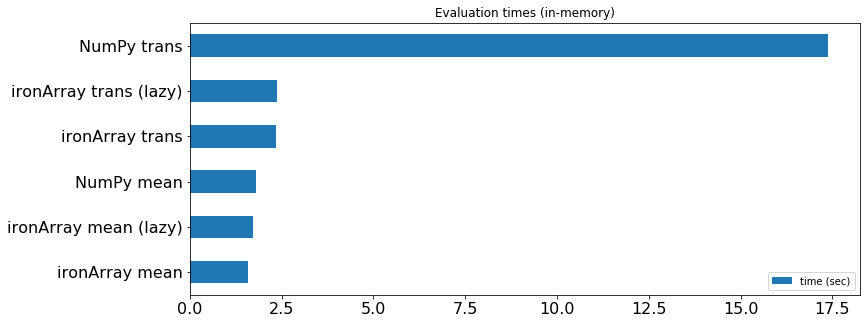

In [23] used 72.215 MiB RAM in 0.778s, peaked 0.000 MiB above current, total RAM usage 8016.848 MiB


In [23]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean",
          "ironArray mean (lazy)",
          "NumPy mean",
          "ironArray trans",
          "ironArray trans (lazy)",
          "NumPy trans"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean"].time_delta,
    meas["ia_mean_lazy"].time_delta,
    meas["np_mean"].time_delta,
    meas["ia_trans"].time_delta,
    meas["ia_trans_lazy"].time_delta,
    meas["np_trans"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (in-memory)")

and the memory used for every kind of computations:

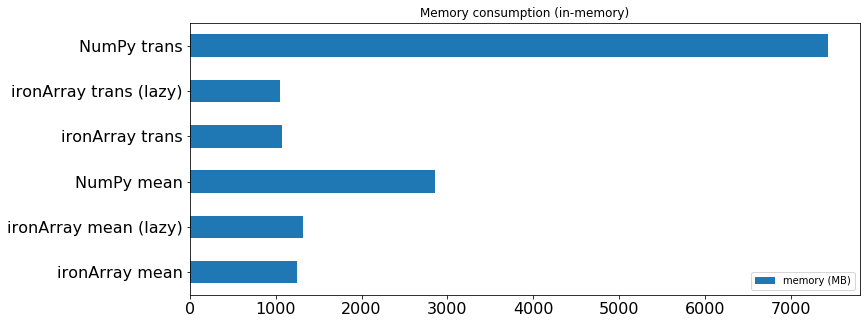

In [24] used 0.777 MiB RAM in 0.119s, peaked 0.000 MiB above current, total RAM usage 8017.625 MiB


In [24]:
labels = [
    "ironArray mean",
    "ironArray mean (lazy)",
    "NumPy mean",
    "ironArray trans",
    "ironArray trans (lazy)",
    "NumPy trans"]
df = pd.DataFrame({'memory (MB)': [
    meas["ia_mean"].memory_delta,
    meas["ia_mean_lazy"].memory_delta,
    meas["np_mean"].memory_delta,
    meas["ia_trans"].memory_delta,
    meas["ia_trans_lazy"].memory_delta,
    meas["np_trans"].memory_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Memory consumption (in-memory)")

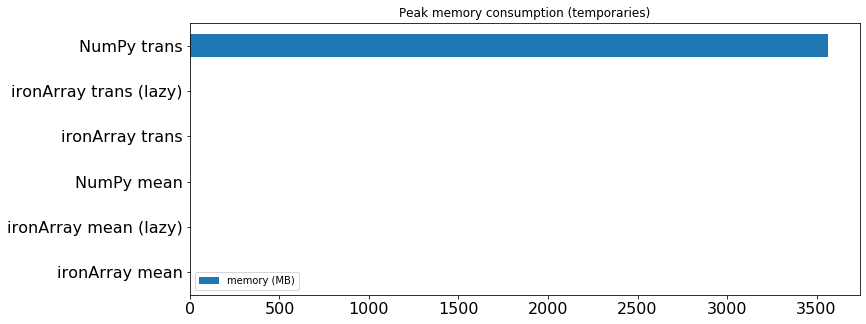

In [25] used 2.383 MiB RAM in 0.121s, peaked 0.000 MiB above current, total RAM usage 8020.008 MiB


In [25]:
labels = [
    "ironArray mean",
    "ironArray mean (lazy)",
    "NumPy mean",
    "ironArray trans",
    "ironArray trans (lazy)",
    "NumPy trans"]
df = pd.DataFrame({'memory (MB)': [
    meas["ia_mean"].memory_peak,
    meas["ia_mean_lazy"].memory_peak,
    meas["np_mean"].memory_peak,
    meas["ia_trans"].memory_peak,
    meas["ia_trans_lazy"].memory_peak,
    meas["np_trans"].memory_peak]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Peak memory consumption (temporaries)")

## Optimization Tips

Even if ironArray has been quite competitive in terms of speed and memory consumption, so far the computations have been done using just the default values.  Let's see how we can accelerate things here.

First, let's start by using larger chunks and see.  First, let's see which are our current sizes:

In [26]:
print(precip1.chunkshape)
print(precip1.blockshape)

(64, 64, 128)
(16, 16, 64)
In [26] used 0.035 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 8020.043 MiB


Let's duplicate

TODO: Introduce UDFs, and an 'Optimization tips' section...

TODO: Add a comparison with xarray or dask, for out-of-core reductions

In [27]:
mw.stop_watching_memory()